## 导入所需库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings 
warnings.filterwarnings('ignore')

import eli5
import shap

import sys

sys.path.append("/home/birch/data_tools/")

from insight.df_preview import DfInfo
dfi = DfInfo.DataFrameInfo

from tqdm import tqdm

In [2]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('testA.csv')

In [3]:
# 深拷贝数据集，以确保所有修改都不涉及原数据
train_df = train_set.copy()
test_df = test_set.copy()

In [4]:
# 以下几行重复，需要进行删除
print(np.sum(train_df['n2'] - train_df['n2.1']))
print(np.sum(test_df['n2'] - test_df['n2.1']))
print(np.sum(test_df['n2'] - test_df['n2.2']))
print(np.sum(test_df['n2'] - test_df['n2.3']))

0.0
0.0
0.0
0.0


In [5]:
train_df.drop(columns=['n2.1'], inplace=True)
test_df.drop(columns=['n2.1', 'n2.2', 'n2.3'], inplace=True)

In [6]:
def check_nearest_dataset_shape():
    print(f'train_df:{train_df.shape}')
    print(f'test_df:{test_df.shape}')
check_nearest_dataset_shape()

train_df:(800000, 46)
test_df:(200000, 45)


## 定义内存管理器，节约内存开销

In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook


class _Data_Preprocess:
    def __init__(self):
        self._int8_max = np.iinfo(np.int8).max
        self._int8_min = np.iinfo(np.int8).min

        self._int16_max = np.iinfo(np.int16).max
        self._int16_min = np.iinfo(np.int16).max

        self._int32_max = np.iinfo(np.int32).max
        self._int32_min = np.iinfo(np.int32).min

        self._int64_max = np.iinfo(np.int64).max
        self._int64_min = np.iinfo(np.int64).min

        self._float16_max = np.finfo(np.float16).max
        self._float16_min = np.finfo(np.float16).min

        self._float32_max = np.finfo(np.float32).max
        self._float32_min = np.finfo(np.float32).min

        self._float64_max = np.finfo(np.float64).max
        self._float64_min = np.finfo(np.float64).min

    def _get_type(self, min_val, max_val, types):
        if types == 'int':
            if max_val <= self._int8_max and min_val >= self._int8_min:
                return np.int8
            elif max_val <= self._int16_max and min_val >= self._int16_min:
                return np.int16
            elif max_val <= self._int32_max and min_val >= self._int32_min:
                return np.int32
            elif max_val <= self._int64_max and min_val >= self._int64_min:
                return np.int64
            return None

        elif types == 'float':
            if max_val <= self._float16_max and min_val >= self._float16_min:
                return np.float16
            elif max_val <= self._float32_max and min_val >= self._float32_min:
                return np.float32
            elif max_val <= self._float64_max and min_val >= self._float64_min:
                return np.float64
            return None

    def memory_process(self, df):
        init_memory = df.memory_usage().sum() / 1024 ** 2
        print(f"Original data occupies {round(init_memory, 2)} MB memory.")

        df_cols = df.columns

        for col in tqdm_notebook(df_cols):
            try:
                if 'float' in str(df[col].dtypes):
                    max_val = df[col].max()
                    min_val = df[col].min()
                    trans_types = self._get_type(min_val, max_val, 'float')
                    if trans_types is not None:
                        df[col] = df[col].astype(trans_types)
                elif 'int' in str(df[col].dtypes):
                    max_val = df[col].max()
                    min_val = df[col].min()
                    trans_types = self._get_type(min_val, max_val, 'int')
                    if trans_types is not None:
                        df[col] = df[col].astype(trans_types)
            except Exception:
                print(f'Can not do any process for column, {col}')

        afterprocess_memory = df.memory_usage().sum() / 1024 ** 2 
        print(f'After processing, the data occupies {round(afterprocess_memory, 2)} MB memory.')

        return df

memory_process = _Data_Preprocess()

In [8]:
train_df = memory_process.memory_process(train_df)
test_df = memory_process.memory_process(test_df)

Original data occupies 280.76 MB memory.



After processing, the data occupies 93.08 MB memory.
Original data occupies 68.66 MB memory.



After processing, the data occupies 23.08 MB memory.


## 数据预处理

In [9]:
# 筛选出数值特征和类别特征
numerical_fea = list(train_df.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(train_df.columns)))
label = 'isDefault'
numerical_fea.remove(label)

**缺失值填充**
- 把所有缺失值替换为指定的值0

train_df = train_df.fillna(0)

- 向用缺失值上面的值替换为缺失值

train_df = train_df.fillna(axis=0, method='ffill')

- 纵向用缺失值下面的值替换缺失值，且设置最多只填充两个连续的缺失值

train_df = train_df.fillna(axis=0, method='bfill', limit=2)

In [10]:
# 查看各列的缺失值
train_df.isna().sum().sort_values(ascending=False)

n11                   69752
employmentLength      46799
n8                    40271
n14                   40270
n6                    40270
n0                    40270
n2                    40270
n5                    40270
n1                    40270
n7                    40270
n9                    40270
n12                   40270
n13                   40270
n4                    33239
n10                   33239
revolUtil               531
pubRecBankruptcies      405
dti                     239
employmentTitle           1
postCode                  1
title                     1
verificationStatus        0
annualIncome              0
homeOwnership             0
term                      0
subGrade                  0
grade                     0
installment               0
interestRate              0
isDefault                 0
loanAmnt                  0
issueDate                 0
pubRec                    0
purpose                   0
regionCode                0
delinquency_2years  

In [11]:
print(numerical_fea)
print(category_fea)

['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'employmentTitle', 'homeOwnership', 'annualIncome', 'verificationStatus', 'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc', 'initialListStatus', 'applicationType', 'title', 'policyCode', 'n0', 'n1', 'n2', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14']
['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']


In [22]:
#按照中位数填充数值型特征
train_df[numerical_fea] = train_df[numerical_fea].fillna(train_df[numerical_fea].median())
test_df[numerical_fea] = test_df[numerical_fea].fillna(test_df[numerical_fea].median())
#按照众数填充类别型特征
train_df[category_fea] = train_df[category_fea].fillna(train_df[category_fea].mode())
test_df[category_fea] = test_df[category_fea].fillna(test_df[category_fea].mode())

In [23]:
train_df.isna().sum().sort_values(ascending=False)

employmentLength      46799
n14                       0
verificationStatus        0
ficoRangeHigh             0
ficoRangeLow              0
delinquency_2years        0
dti                       0
regionCode                0
postCode                  0
purpose                   0
isDefault                 0
issueDate                 0
annualIncome              0
pubRec                    0
homeOwnership             0
employmentTitle           0
subGrade                  0
grade                     0
installment               0
interestRate              0
term                      0
loanAmnt                  0
openAcc                   0
pubRecBankruptcies        0
n13                       0
n2.1                      0
n12                       0
n11                       0
n10                       0
n9                        0
n8                        0
n7                        0
n6                        0
n5                        0
n4                        0
n2                  

## 对象型类别特征需要处理

处理时间格式数据

In [12]:
# 转化为时间格式
for data in [train_df, test_df]:
    data['issueDate'] = pd.to_datetime(data['issueDate'], format='%Y-%m-%d')
    startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
    # 构造时间特征
    data['issueDateDT'] = data['issueDate'].apply(lambda s: s - startdate).dt.days
    data.drop(columns='issueDate', inplace=True)

对象类型特征转换为数值

In [13]:
train_df['employmentLength'].value_counts(dropna=False).sort_index()

1 year        52489
10+ years    262753
2 years       72358
3 years       64152
4 years       47985
5 years       50102
6 years       37254
7 years       35407
8 years       36192
9 years       30272
< 1 year      64237
NaN           46799
Name: employmentLength, dtype: int64

In [14]:
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
for data in [train_df, test_df]:
    data['employmentLength'].replace(['10+ years', '< 1 year'], ['10 years', '0 year'], inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [27]:
for data in [train_df, test_df]:
    data['employmentLength'].fillna(-999, inplace=True)

In [28]:
train_df['employmentLength'].value_counts(dropna=False).sort_index()

-999.0     46799
 0.0       64237
 1.0       52489
 2.0       72358
 3.0       64152
 4.0       47985
 5.0       50102
 6.0       37254
 7.0       35407
 8.0       36192
 9.0       30272
 10.0     262753
Name: employmentLength, dtype: int64

对earliesCreditLine进行预处理

In [15]:
train_df['earliesCreditLine'].sample(5)

174814    Apr-1998
434442    Jan-2000
727779    Jun-1984
682147    Dec-1995
799697    Apr-1985
Name: earliesCreditLine, dtype: object

In [16]:
# 只需要年份就行
for data in [train_df, test_df]:
    data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda s: int(s[-4:]))

In [17]:
train_df['earliesCreditLine'].sample(5)

447190    1993
657759    1999
665187    2003
592544    2003
213001    2002
Name: earliesCreditLine, dtype: int64

类别特征处理

In [18]:
# 部分类别特征
cate_features = ['grade', 'subGrade', 'employmentTitle', 'homeOwnership', 'verificationStatus', \
                 'purpose', 'postCode', 'regionCode', 'applicationType', 'initialListStatus', \
                 'title', 'policyCode']
for i in cate_features:
    print(f"{i} 类型数为 {train_df[i].nunique()}")

grade 类型数为 7
subGrade 类型数为 35
employmentTitle 类型数为 248683
homeOwnership 类型数为 6
verificationStatus 类型数为 3
purpose 类型数为 14
postCode 类型数为 932
regionCode 类型数为 51
applicationType 类型数为 2
initialListStatus 类型数为 2
title 类型数为 6509
policyCode 类型数为 1


像等级这种类别特征，是有优先级的可以label-encode或者自映射

In [19]:
# 定义顺序编码器 ordinal encoder
def ordinal_map(data:pd.DataFrame, col:str) -> pd.Series:
    index = data[col].value_counts().index.unique().sort_values() 
    index_len = len(index)
    map_dict = {}
    for i, j in zip(index, range(1, index_len+1)):
        map_dict[i] = j 
    _ = data[col].map(map_dict, na_action='ignore')
    return _

In [20]:
# 对等级类别使用label-encoder
for data in [train_df, test_df]:
    data['grade'] = ordinal_map(data, 'grade')
    data['subGrade'] = ordinal_map(data, 'subGrade')

In [35]:
# 数据没有前后顺序的，并且特征类型数较少的的离散型变量可以使用ont-hot encoder
one_hot_list = ['homeOwnership', 'verificationStatus', 'purpose', 'applicationType', 'initialListStatus']

train_df = pd.get_dummies(train_df, columns=one_hot_list, drop_first=True)
test_df = pd.get_dummies(test_df, columns=one_hot_list, drop_first=True)

In [36]:
check_nearest_dataset_shape()

train_df:(800000, 64)
test_df:(200000, 65)


In [37]:
numerical_fea = [i for i in numerical_fea if i not in one_hot_list]

## 异常值处理

- 当你发现异常值后，一定要先分清是什么原因导致的异常值，然后再考虑如何处理。首先，如果这一异常值并不代表一种规律性的，而是极其偶然的现象，或者说你并不想研究这种偶然的现象，这时可以将其删除。其次，如果异常值存在且代表了一种真实存在的现象，那就不能随便删除。在现有的欺诈场景中很多时候欺诈数据本身相对于正常数据来说就是异常的，我们要把这些异常点纳入，重新拟合模型，研究其规律。能用监督的用监督模型，不能用的还可以考虑用异常检测的算法来做。
- 注意test的数据不能删。

#### 检测异常的方法：均方差
在统计学中，如果一个数据分布近似正态，那么大约 68% 的数据值会在均值的一个标准差范围内，大约 95% 会在两个标准差范围内，大约 99.7% 会在三个标准差范围内。

In [28]:
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:str('异常值') if x > upper_rule 
                                            or x < lower_rule else '正常值')
    return data

In [29]:
for fea in numerical_fea:
    train_df = find_outliers_by_3segama(train_df,fea)
    print(train_df[fea+'_outliers'].value_counts())
    print(train_df.groupby(fea+'_outliers')['isDefault'].sum())
    print('*'*50)

正常值    800000
Name: id_outliers, dtype: int64
id_outliers
正常值    159610.0
Name: isDefault, dtype: float64
**************************************************
正常值    800000
Name: loanAmnt_outliers, dtype: int64
loanAmnt_outliers
正常值    159610.0
Name: isDefault, dtype: float64
**************************************************
正常值    800000
Name: term_outliers, dtype: int64
term_outliers
正常值    159610.0
Name: isDefault, dtype: float64
**************************************************
正常值    800000
Name: interestRate_outliers, dtype: int64
interestRate_outliers
正常值    159610.0
Name: isDefault, dtype: float64
**************************************************
正常值    800000
Name: installment_outliers, dtype: int64
installment_outliers
正常值    159610.0
Name: isDefault, dtype: float64
**************************************************
正常值    800000
Name: employmentTitle_outliers, dtype: int64
employmentTitle_outliers
正常值    159610.0
Name: isDefault, dtype: float64
*****************************

In [30]:
#删除异常值
for fea in numerical_fea:
    train_df = train_df[train_df[fea+'_outliers']=='正常值']
    train_df = train_df.reset_index(drop=True)
    train_df.drop(columns=[fea+'_outliers'], inplace=True)

In [31]:
check_nearest_dataset_shape()

train_df:(782396, 63)
test_df:(200000, 62)


## 数据分桶

特别要注意一下分箱的基本原则：

（1）最小分箱占比不低于5%
（2）箱内不能全部是好客户
（3）连续箱单调

In [32]:
from sklearn.tree import DecisionTreeClassifier
# 使用决策树进行分箱
def optimal_binning_boundary(x:pd.Series, y:pd.Series, nan:float = -999.) -> list:
    """
    利用决策树获得最优分箱的边界值列表
    """
    boundary = [] # 待return的分箱边界值列表
    
    x = x.fillna(nan).values
    y = y.values

    clf = DecisionTreeClassifier(criterion='entropy', # 信息熵最小化准则划分
                                 max_leaf_nodes=12,  # 最大叶子节点数, 即需要分为几层
                                 min_samples_leaf=0.05) # 叶子节点样本数量最小占比
    clf.fit(x.reshape(-1, 1), y)  # 训练决策树
    
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left   
    children_right = clf.tree_.children_right
    threshold = clf.tree_.threshold
    
    for i in range(n_nodes):
        if children_left[i] != children_right[i]:  # 获得决策树节点上的划分边界值
            boundary.append(threshold[i])
    
    boundary.sort()
    
    min_x = x.min()
    max_x = x.max() + 0.1 # +0.1是为了考虑后续groupby操作时，能包含特征最大值的样本
    boundary = [min_x] + boundary + [max_x]
    
    return boundary


            

In [33]:
# 筛选连续性变量特征
def get_numericla_serial_fea(data, feas):
    _ = []
    for fea in feas:
        if data[fea].nunique() > 10:
            _.append(fea)
    return _
need2cut_fea = get_numericla_serial_fea(train_df, numerical_fea)

for i in ['id', 'employmentTitle', 'postCode', 'regionCode', 'title', 'openAcc', 'pubRec', \
          'pubRecBankruptcies']:
    need2cut_fea.remove(i)

In [34]:
need2cut_fea

['loanAmnt',
 'interestRate',
 'installment',
 'annualIncome',
 'dti',
 'delinquency_2years',
 'ficoRangeLow',
 'ficoRangeHigh',
 'revolBal',
 'revolUtil',
 'totalAcc',
 'n0',
 'n1',
 'n2',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n13',
 'n14']

In [35]:
# 对连续型变量分箱处理
for col in need2cut_fea:
    boundary = optimal_binning_boundary(train_df[col], train_df['isDefault'])
    train_df[col+'_bins'] = pd.cut(x=train_df[col], bins=boundary, right=False)
    test_df[col+'_bins'] = pd.cut(x=train_df[col], bins=boundary, right=False)


In [36]:
# 对每一个分箱列使用顺序编码器
for col in need2cut_fea:
    new_col = col+'_bins'
    train_df[col+'_bins'] = ordinal_map(train_df, new_col)
    test_df[col+'_bins'] = ordinal_map(test_df, new_col)

In [37]:
train_df.iloc[:, -10:-1]

,n2_bins,n4_bins,n5_bins,n6_bins,n7_bins,n8_bins,n9_bins,n10_bins,n13_bins
0,1,4,8,7,2,6,1,3,1
1,4,8,6,6,5,7,4,8,1
2,2,1,1,11,2,1,2,6,1
3,5,4,12,3,5,11,5,5,1
4,6,2,3,8,8,8,6,7,1
...,...,...,...,...,...,...,...,...,...
782391,8,6,5,2,10,7,8,9,1
782392,1,2,11,10,1,10,1,3,1
782393,3,1,3,12,2,4,3,1,2
782394,7,7,9,5,10,11,7,10,1


In [38]:
test_df.iloc[:, -10:-1]

,n2_bins,n4_bins,n5_bins,n6_bins,n7_bins,n8_bins,n9_bins,n10_bins,n13_bins
0,1,4,8,7,2,6,1,3,1
1,4,8,6,6,5,7,4,8,1
2,2,1,1,11,2,1,2,6,1
3,5,4,12,3,5,11,5,5,1
4,6,2,3,8,8,8,6,7,1
...,...,...,...,...,...,...,...,...,...
199995,2,2,2,10,1,1,2,11,1
199996,9,8,11,1,10,11,7,8,1
199997,6,6,12,6,10,12,6,11,1
199998,8,6,7,4,9,8,8,8,1


In [39]:
# 删除原有的未分箱的列
train_df.drop(columns=need2cut_fea, inplace=True)
test_df.drop(columns=need2cut_fea, inplace=True)

In [40]:
check_nearest_dataset_shape()

train_df:(782396, 63)
test_df:(200000, 62)


### label-encoder

In [41]:
need2labelencode = ['employmentTitle', 'postCode', 'regionCode', 'title', 'earliesCreditLine']

In [42]:
# 高维类别特征需要进行转换
from sklearn.preprocessing import LabelEncoder
for col in tqdm_notebook(need2labelencode):
    le = LabelEncoder()
    le.fit(list(train_df[col].astype(str).values) + list(test_df[col].astype(str).values))
    train_df[col] = le.transform(list(train_df[col].astype(str).values))
    test_df[col] = le.transform(list(test_df[col].astype(str).values))
print('Label Encoding 完成')


Label Encoding 完成


### 查看各列缺失值和唯一值情况

In [43]:
nullAndUnique = pd.DataFrame(train_df.isna().sum().sort_values(ascending=False), columns=['null'])
nullAndUnique['nunique'] = train_df.nunique()
nullAndUnique

,null,nunique
n14_bins,0,6
n11,0,1
purpose_4,0,2
purpose_3,0,2
purpose_2,0,2
...,...,...
purpose_12,0,2
purpose_11,0,2
purpose_10,0,2
purpose_9,0,2


In [44]:
# 删除掉值唯一和id列
useless_col = ['id']
useless_col = useless_col + nullAndUnique.query('nunique < 2').index.to_list()
useless_col

['id', 'n11', 'n12', 'policyCode']

In [45]:
for data in [train_df, test_df]:
    data.drop(columns=useless_col, inplace=True)

In [46]:
check_nearest_dataset_shape()

train_df:(782396, 59)
test_df:(200000, 58)


## 特征交互

In [47]:
train_df.columns

Index(['term', 'grade', 'subGrade', 'employmentTitle', 'employmentLength',
       'isDefault', 'postCode', 'regionCode', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'earliesCreditLine', 'title', 'issueDateDT',
       'homeOwnership_1', 'homeOwnership_2', 'homeOwnership_3',
       'homeOwnership_4', 'homeOwnership_5', 'verificationStatus_1',
       'verificationStatus_2', 'purpose_1', 'purpose_2', 'purpose_3',
       'purpose_4', 'purpose_5', 'purpose_6', 'purpose_7', 'purpose_8',
       'purpose_9', 'purpose_10', 'purpose_11', 'purpose_12', 'purpose_13',
       'applicationType_1', 'initialListStatus_1', 'loanAmnt_bins',
       'interestRate_bins', 'installment_bins', 'annualIncome_bins',
       'dti_bins', 'delinquency_2years_bins', 'ficoRangeLow_bins',
       'ficoRangeHigh_bins', 'revolBal_bins', 'revolUtil_bins',
       'totalAcc_bins', 'n0_bins', 'n1_bins', 'n2_bins', 'n4_bins', 'n5_bins',
       'n6_bins', 'n7_bins', 'n8_bins', 'n9_bins', 'n10_bins', 'n13_bins',
       'n14

In [48]:
train_df[train_df.select_dtypes(include='category').columns] = train_df.select_dtypes(include='category')\
                                                                .astype(np.float16)
test_df[test_df.select_dtypes(include='category').columns] = test_df.select_dtypes(include='category')\
                                                                .astype(np.float16)

In [49]:
train_df.columns

Index(['term', 'grade', 'subGrade', 'employmentTitle', 'employmentLength',
       'isDefault', 'postCode', 'regionCode', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'earliesCreditLine', 'title', 'issueDateDT',
       'homeOwnership_1', 'homeOwnership_2', 'homeOwnership_3',
       'homeOwnership_4', 'homeOwnership_5', 'verificationStatus_1',
       'verificationStatus_2', 'purpose_1', 'purpose_2', 'purpose_3',
       'purpose_4', 'purpose_5', 'purpose_6', 'purpose_7', 'purpose_8',
       'purpose_9', 'purpose_10', 'purpose_11', 'purpose_12', 'purpose_13',
       'applicationType_1', 'initialListStatus_1', 'loanAmnt_bins',
       'interestRate_bins', 'installment_bins', 'annualIncome_bins',
       'dti_bins', 'delinquency_2years_bins', 'ficoRangeLow_bins',
       'ficoRangeHigh_bins', 'revolBal_bins', 'revolUtil_bins',
       'totalAcc_bins', 'n0_bins', 'n1_bins', 'n2_bins', 'n4_bins', 'n5_bins',
       'n6_bins', 'n7_bins', 'n8_bins', 'n9_bins', 'n10_bins', 'n13_bins',
       'n14

In [50]:
for data in [train_df, test_df]:
    data['region_loan'] = data['loanAmnt_bins'] * data['regionCode']
    data['grade_loan'] = data['grade'] * data['loanAmnt_bins']
    data['dti_pubRec'] = data['pubRec'] * data['dti_bins']


n_fea = ['n0_bins',  'n1_bins', 'n2_bins', 'n4_bins', 'n5_bins',\
 'n6_bins', 'n7_bins', 'n8_bins', 'n9_bins', 'n10_bins', 'n13_bins', 'n14_bins']

for data in [train_df, test_df]:
    for item in n_fea:
        data['grade_to_mean_' + item] = data['grade'] / data.groupby([item])['grade'].transform('mean')
        data['grade_to_std_' + item] = data['grade'] / data.groupby([item])['grade'].transform('std')

In [51]:
check_nearest_dataset_shape()

train_df:(782396, 86)
test_df:(200000, 85)


In [52]:
train_df = memory_process.memory_process(train_df)
test_df = memory_process.memory_process(test_df)

Original data occupies 267.1221694946289 MB memory.



After processing, the data occupies 113.41506958007812 MB memory.
Original data occupies 68.09246826171875 MB memory.



After processing, the data occupies 28.80108642578125 MB memory.


## 特征选择

- 使用各类特征选择方式选择特征，最后取交集
    - 互信息法
    - 树类模型筛选法
    - shap、eli5特征选择
    
    

In [53]:
# 定义一个集合用来存储选择后的特征
final_feas = ()

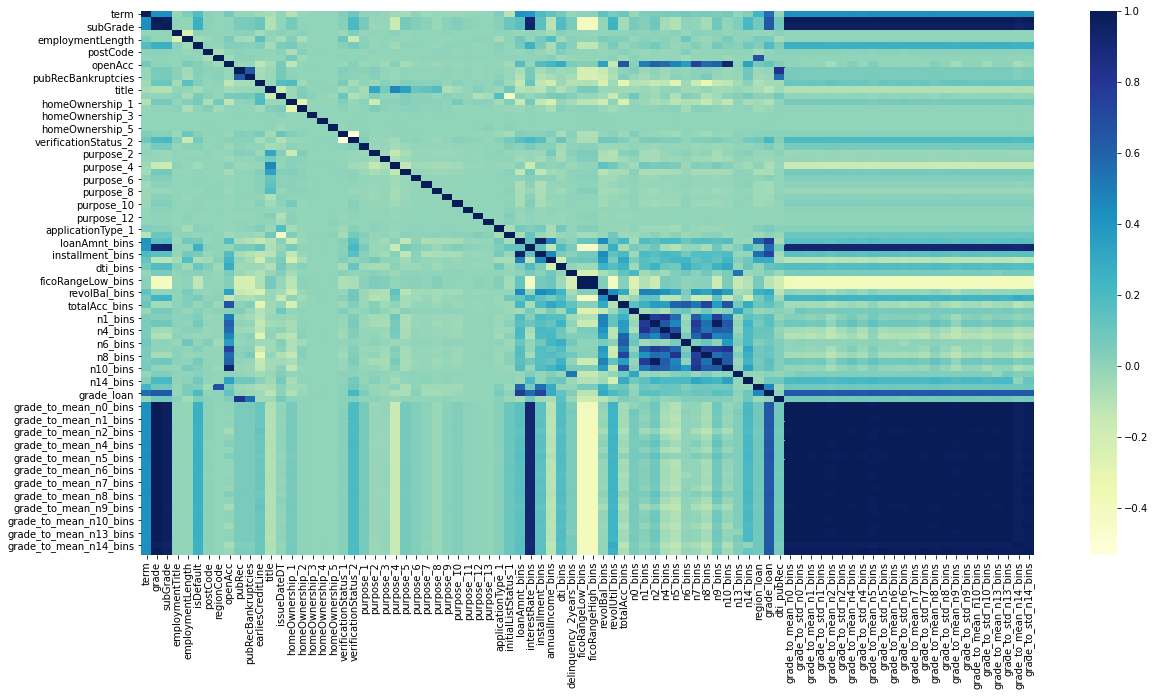

In [54]:
corr = train_df.corr('pearson')
plt.figure(figsize=(20, 10))
sns.heatmap(corr,  cmap="YlGnBu")
plt.show()

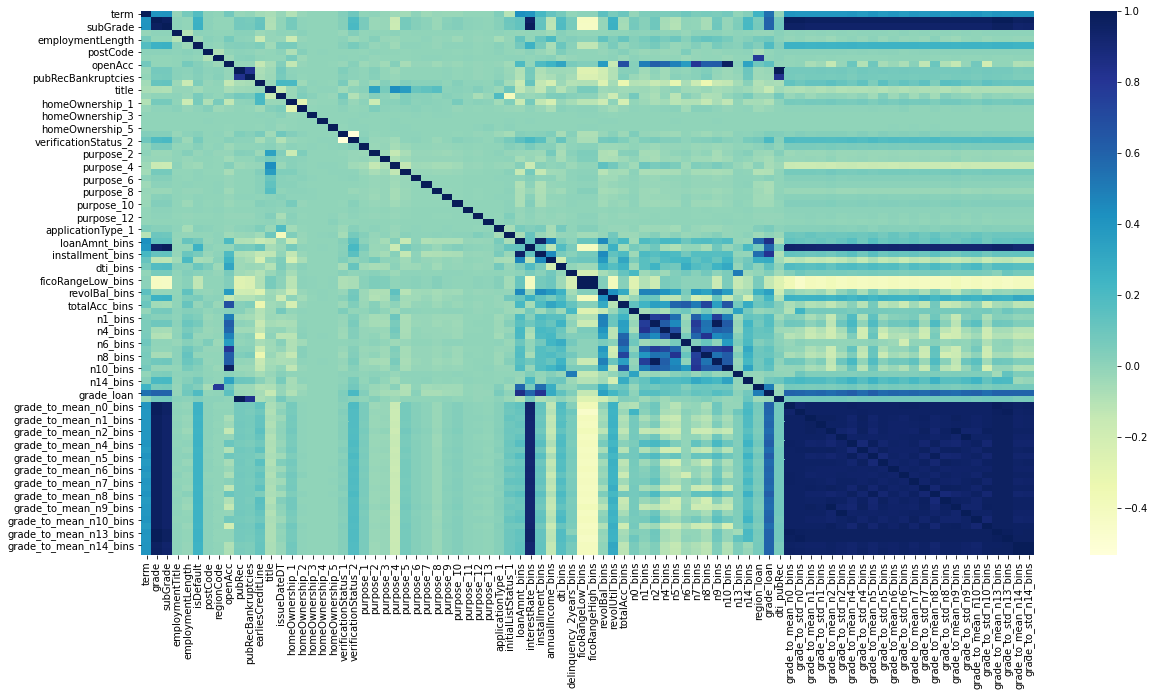

In [55]:
corr = train_df.corr('spearman')
plt.figure(figsize=(20, 10))
sns.heatmap(corr,cmap="YlGnBu")
plt.show()

可以看到很多特征出现了多重共线性，需要进行特征筛选

In [56]:
corr = train_df.corr()

### 使用互信息法筛选特征

In [57]:
# 划分features和target
x = train_df[train_df.columns[train_df.columns != 'isDefault']]
y = train_df['isDefault']

In [58]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

skb = SelectKBest(mutual_info_classif).fit(x, y)
print(np.round(skb.scores_, 2))

[0.09 0.06 0.04 0.01 0.01 0.   0.01 0.01 0.   0.   0.01 0.02 0.01 0.02
 0.   0.   0.   0.   0.02 0.01 0.   0.   0.   0.01 0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.02 0.01 0.05 0.01 0.01 0.02 0.07 0.02
 0.02 0.01 0.02 0.01 0.07 0.02 0.02 0.02 0.01 0.01 0.01 0.01 0.02 0.01
 0.11 0.02 0.   0.03 0.   0.05 0.05 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.06 0.06 0.04
 0.04]


In [59]:
mutual_info_fea = set(x.columns[skb.scores_ > 0].to_list())

In [60]:
len(mutual_info_fea)

80

In [61]:
check_nearest_dataset_shape()

train_df:(782396, 86)
test_df:(200000, 85)


### 使用随机森林从互信息筛选后结果中选择满足条件的特征

In [62]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=2020)
rfc.fit(x, y)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=2020)

In [63]:
rfc_fea = x.columns[rfc.feature_importances_ >= 0.015].to_list()
rfc_fea = set(rfc_fea)

In [64]:
len(rfc_fea)

29

In [65]:
final_feas = mutual_info_fea | rfc_fea

In [66]:
len(final_feas)

80

## 使用eli5观察特征重要性

In [67]:
rfc_eli5 = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=2020)
rfc_eli5.fit(x, y)
eli5.show_weights(rfc_eli5, feature_names=x.columns.to_list())

Weight,Feature
0.0381 ± 0.0013,postCode
0.0378 ± 0.0018,employmentTitle
0.0376 ± 0.0016,issueDateDT
0.0320 ± 0.0013,region_loan
0.0315 ± 0.0014,earliesCreditLine
0.0266 ± 0.0010,regionCode
0.0226 ± 0.0012,annualIncome_bins
0.0223 ± 0.0017,dti_bins
0.0215 ± 0.0007,revolUtil_bins
0.0212 ± 0.0011,revolBal_bins


In [71]:
a = eli5.explain_weights_df(rfc_eli5, feature_names=x.columns.to_list())

In [79]:
eli5_fea = set(a.query('weight > 5e-3').feature.values)

In [ ]:
len(eli5_fea)

### 使用shap观察特征重要性

In [81]:
x.shape

(782396, 85)

In [82]:
check_nearest_dataset_shape()

train_df:(782396, 86)
test_df:(200000, 85)


In [83]:
sample = train_df.sample(10000)
x_sample = sample[sample.columns[sample.columns != 'isDefault']]
y_sample = sample['isDefault']

In [85]:
rfc_shap = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=2020)
rfc_shap.fit(x_sample, y_sample)

explainer = shap.TreeExplainer(rfc_shap)
shap_values = explainer.shap_values(x_sample)

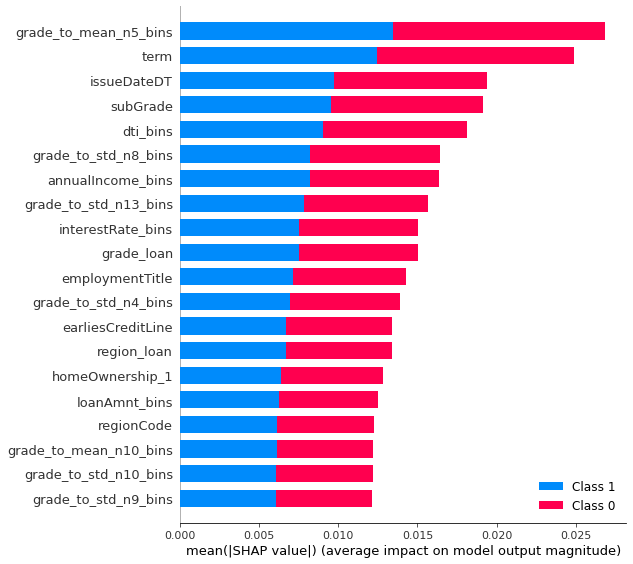

In [87]:
shap.initjs()
shap.summary_plot(shap_values, x_sample)

In [89]:
shap_fea = set(['grade_to_mean_n5_bins', 'term', 'issueDateDT', 'subGrade', 'dti_bins', \
                'grade_to_std_n8_bins', 'annualIncome_bins', 'grade_to_std_n13_bins', \
               'interestRate_bins', 'grade_loan', 'employmentTitle', 'grade_to_std_n4_bins', \
               'earliesCreditLine', 'region_loan', 'homeOwnership_1', 'loanAmnt_bins', \
               'regionCode', 'grade_to_mean_n10_bins', 'grade_to_std_n10_bins', 'grade_to_std_n9_bins'])

### 求特征交集

In [90]:
final_feas = mutual_info_fea & rfc_fea & eli5_fea & shap_fea
len(final_feas)

13

In [92]:
final_feas = list(final_feas)

In [95]:
X, y = x[final_feas], y

## 建模预测

In [13]:
import lightgbm
import xgboost
from catboost import CatBoost
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [100]:
test_df_processed = test_df[final_feas]

In [27]:
def cv_model(clf, train_x, train_y, test_x, clf_name):
    folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], \
                            train_x.iloc[valid_index],train_y[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': -1,
                'n_jobs':-1,
                'verbose': -1,
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], 
                              verbose_eval=200,early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
#             print(list(sorted(zip(features, model.feature_importance("gain")), 
#                     key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': 'exact',
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, 
                              verbose_eval=200, early_stopping_rounds=200)
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(test_x , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
            
        train[valid_index] = val_pred
        test = test_pred / kf.n_splits
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
        print(cv_scores)
        
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    return train, test

In [10]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test = cv_model(lightgbm, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test = cv_model(xgboost, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test

def cat_model(x_train, y_train, x_test):
    cat_train, cat_test = cv_model(CatBoost, x_train, y_train, x_test, "cat")

In [25]:
X = train_df[train_df.columns[train_df.columns != 'isDefault']]
y = train_df['isDefault']
lgb_train, lgb_test = lgb_model(X, y, test_df)

************************************ 1 ************************************
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=24 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.748111	valid_1's auc: 0.736277
[400]	training's auc: 0.761034	valid_1's auc: 0.737143
[600]	training's auc: 0.771474	valid_1's auc: 0.737159
Early stopping, best iteration is:
[543]	training's auc: 0.768689	valid_1's auc: 0.737311
[0.7373105008068606]
************************************ 2 ************************************
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=24 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.74878	valid_1's auc: 0.732769
[400]	training's auc: 0.76164	valid_1's auc: 0.733635
[600]	training's auc: 0.772369	valid_1's auc: 0.733983
[800]	training's auc: 0.782224	valid_1's auc: 0.733876
Ea

In [28]:
sample = pd.read_csv('sample_submit.csv')
sample

,id,isDefault
0,800000,0.5
1,800001,0.5
2,800002,0.5
3,800003,0.5
4,800004,0.5
...,...,...
199995,999995,0.5
199996,999996,0.5
199997,999997,0.5
199998,999998,0.5


In [29]:
result = sample.copy()
result['isDefault'] = lgb_test

In [30]:
result.to_csv('result.csv', index=False)

In [ ]:
# import os
# os.mkdir('./Processed')

In [110]:
train_df_processed = X.join(y)

In [111]:
train_df_processed

,earliesCreditLine,subGrade,dti_bins,regionCode,grade_to_mean_n10_bins,annualIncome_bins,region_loan,issueDateDT,grade_to_std_n8_bins,grade_to_mean_n5_bins,grade_loan,loanAmnt_bins,employmentTitle,isDefault
0,55,22,5.0,26,1.819336,11.0,312.0,2587,3.912109,1.854492,60.0,12.0,189490,1
1,56,17,11.0,10,1.455078,4.0,80.0,1888,3.029297,1.498047,32.0,8.0,103160,0
2,60,18,8.0,6,1.493164,8.0,24.0,3044,3.103516,1.303711,16.0,4.0,187013,0
3,53,4,6.0,3,0.362305,11.0,12.0,2983,0.774902,0.386719,4.0,4.0,246432,0
4,31,12,12.0,14,1.089844,2.0,14.0,3196,2.333984,1.047852,3.0,1.0,252973,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782391,65,14,7.0,49,1.090820,8.0,539.0,3318,2.273438,1.083984,33.0,11.0,143352,0
782392,43,4,5.0,2,0.363770,10.0,14.0,2131,0.771484,0.379395,7.0,7.0,165896,0
782393,56,13,3.0,9,1.071289,7.0,18.0,3044,2.349609,1.047852,6.0,2.0,136856,1
782394,48,4,11.0,10,0.365234,10.0,80.0,2802,0.774902,0.373047,8.0,8.0,44957,0


In [21]:
train_df.to_csv('./Processed/init_train.csv', index=False)
test_df.to_csv('./Processed/init_test.csv', index=False)